# Apr ??, 2022 ()

**Motivation**: Make group plots (KABA) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Fig dir

In [2]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}
fig_dir = pjoin(fig_dir, 'paper')
os.makedirs(fig_dir, exist_ok=True)

## Prepare

In [3]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 30
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

------------------------------    n_top = 0    ------------------------------

Warning, '5' nans detected . . . filling with ones

hi (from inside fit group) ca2

BOLD (corr)   : : :   ovp: 0.9678,  disj: 0.9429

Ca2  (corr)   : : :   ovp: 0.9598,  disj: 0.9533

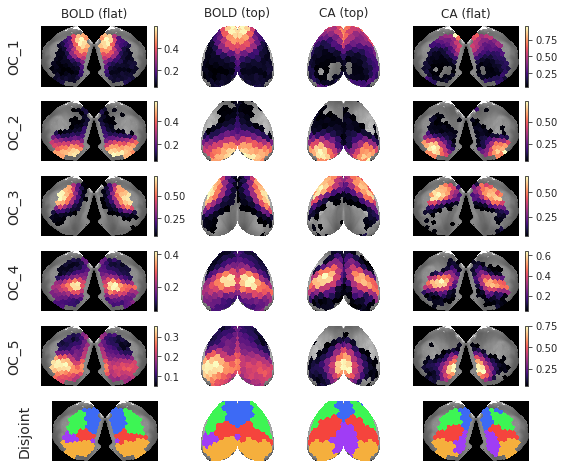

Similarity between OCs (correlation):  Avg = 0.719
OC1: 0.77, OC2: 0.84, OC3: 0.86, OC4: 0.65, OC5: 0.47,

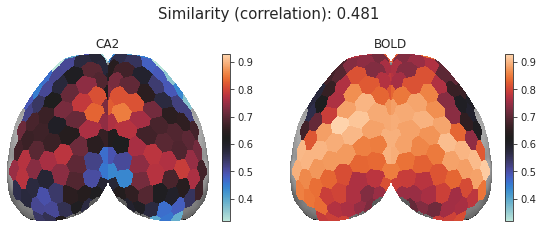

-------------------------------------------------------------------------------

CPU times: user 16min 33s, sys: 2min 2s, total: 18min 36s
Wall time: 8min 9s


In [4]:
%%time

n_top = 0
print('-' * 30, f'   n_top = {n_top}   ', '-' * 30)

gr_ca = Group(**props_ca).fit_group(force=True, n_top=n_top)
gr_bo = Group(**props_bo).fit_group(force=True, n_top=n_top)
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bo.grp_pi,
    XB=gr_ca.grp_pi,
    metric='correlation',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bo.pi = gr_bo.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bo = gr_bo.project_vec()
proj_ca = gr_ca.project_vec()

h = np.concatenate([np.expand_dims(gr_ca.grp_h, 0), np.expand_dims(gr_bo.grp_h, 0)])
proj = gr_ca.project_vec(h, add_disjoint=False)
tr = gr_ca.trim2d(proj)

ovp, disj = gr_bo.pi_symmetry_score(decimals=5, metric='correlation')
print(f"BOLD (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5, metric='correlation')
print(f"Ca2  (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=False,
    min_thres=0.05,
)
score = dist2sim(sp_dist.cdist(gr_bo.pi, gr_ca.pi, metric='correlation')).diagonal()
msg = f'Similarity between OCs (correlation):  Avg = {score.mean():0.3f}\n'
for i in range(num_k):
    msg += f'OC{i+1}: {score[i]:0.2f}, '
msg += '\n'
print(msg)

vmin = np.nanmin(tr['proj-top'][tr['proj-top'].nonzero()])
vmax = np.nanmax(tr['proj-top'][tr['proj-top'].nonzero()])
kwargs = {'cmap': 'icefire', 'vmin': vmin, 'vmax': vmax}

fig, axes = create_figure(1, 2, (8, 3))
for ax in axes.flat:
    ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
im = axes[0].imshow(mwh(tr['proj-top'][0] == 0, tr['proj-top'][0]), **kwargs)
plt.colorbar(im, ax=axes[0])
axes[0].set_title('CA2')
im = axes[1].imshow(mwh(tr['proj-top'][1] == 0, tr['proj-top'][1]), **kwargs)
plt.colorbar(im, ax=axes[1])
axes[1].set_title('BOLD')
sim_h = sp_stats.pearsonr(gr_ca.grp_h, gr_bo.grp_h)[0]
fig.suptitle(f'Similarity (correlation): {sim_h:0.3f}', y=1.04, fontsize=15)
remove_ticks(axes)
plt.show()

print('-' * 79)
print('\n\n')

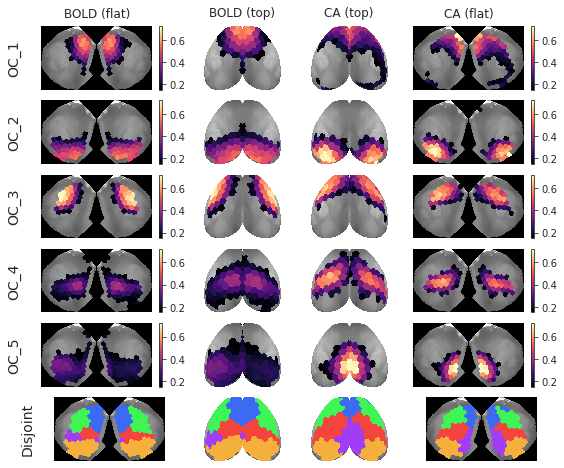

In [8]:
_ = gr_ca.show(
    proj_1=proj_bo,
    proj_2=proj_ca,
    cmaps=('magma',) * 2,
    labels=('BOLD', 'CA'),
    fix_cmap=True,
    min_thres=0.15,
)

------------------------------    n_top = 0    ------------------------------

Warning, '5' nans detected . . . filling with ones

hi (from inside fit group) ca2

[PROGRESS] 'se_indiv-pi_1.0e+02.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/results/SVINET/Gro
up/real_pearson_ca2_k5_p30-sample

[PROGRESS] 'se_indiv-pi_1.0e+02.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/results/SVINET/Gro
up/real_pearson_bold-lite_k5_p30-sample

BOLD (corr)   : : :   ovp: 0.9678,  disj: 0.9429

Ca2  (corr)   : : :   ovp: 0.9768,  disj: 0.9533

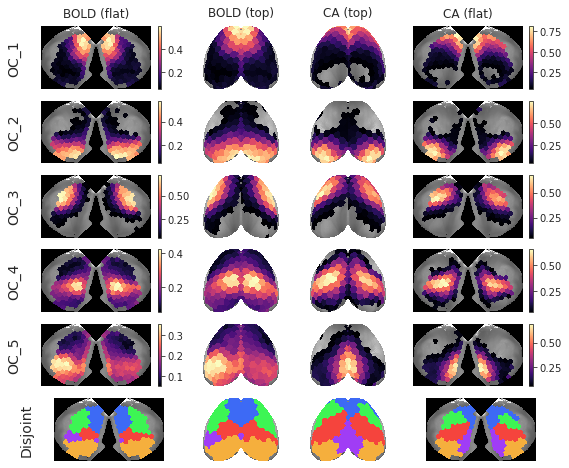

Similarity between OCs (correlation):  Avg = 0.760
OC1: 0.78, OC2: 0.87, OC3: 0.92, OC4: 0.75, OC5: 0.47,

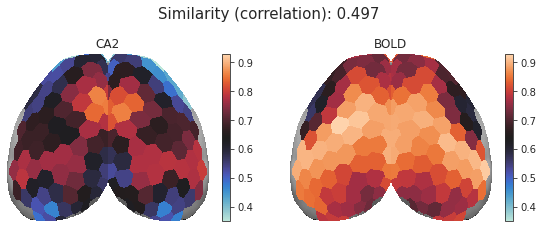

-------------------------------------------------------------------------------

CPU times: user 17min 3s, sys: 1min 14s, total: 18min 17s
Wall time: 7min 8s


In [25]:
x = gr_bo.run_centroids.copy()
x_avg = bn.nanmean(bn.nanmean(bn.nanmean(x, 2), 1), 0)
pi = x_avg / np.nansum(x_avg, -2, keepdims=True)

tr = gr_bo.project_vec(pi)
tr = gr_bo.trim2d(tr)

In [26]:
x_reord = realign_data_runs(x)
x_reord_avg = bn.nanmean(bn.nanmean(bn.nanmean(x_reord, 2), 1), 0)
pi_reord = x_reord_avg / np.nansum(x_reord_avg, -2, keepdims=True)

tr_reord = gr_bo.project_vec(pi_reord)
tr_reord = gr_bo.trim2d(tr_reord)

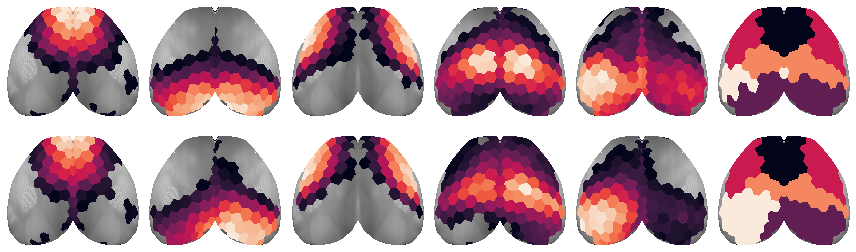

In [27]:
quick_show(tr, tr_reord)

In [28]:
h = sp_stats.entropy(pi, axis=-2) / np.log(5)
h_reord = sp_stats.entropy(pi_reord, axis=-2) / np.log(5)
h_both = np.concatenate([h.reshape(1, -1), h_reord.reshape(1, -1)])

tr_h = gr_bo.project_vec(h_both)
tr_h = gr_bo.trim2d(tr_h)

<matplotlib.image.AxesImage object at 0x7f9689d20310>

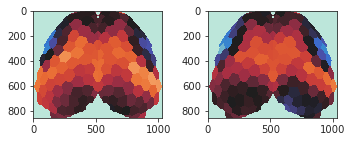

In [31]:
fig, axes = create_figure(1, 2, (5, 3))
axes[0].imshow(tr_h['proj-top'][0], vmin=0.5, vmax=1, cmap='icefire')
axes[1].imshow(tr_h['proj-top'][1], vmin=0.5, vmax=1, cmap='icefire')

In [32]:
x.shape

(10, 3, 4, 5, 154)

In [35]:
i, j, k = x.shape[:3]
data_reord = np_nans(x.shape)
looper = itertools.product(range(i), range(j), range(j))
data_cl = []
for i, j, k in looper:
    _x = x[i, j, k]
    good_nodes = np.where(np.isnan(_x).sum(0) == 0)[0]
    if not len(good_nodes):
        continue
    data_cl.append(_x)
data_cl = np.concatenate(data_cl)
data_cl.shape

(450, 154)

In [36]:
good_nodes = np.where(np.isnan(data_cl).sum(0) == 0)[0]
len(good_nodes)

117

(5, 154)

In [37]:
centroids_meta = np_nans((5, data_cl.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data_cl[:, good_nodes],
    n_clusters=5,
    match_metric='euclidean',
    random_state=mice.cfg.random_state,
)
centroids_meta[:, good_nodes] = _centroids

In [40]:
global_mapping = gr_bo.align_centroid_to_structs(
    pi_mv=centroids_meta,
    dist_metric=gr_bo.dist_metric,
    global_order=False,
)
centroids_meta = centroids_meta[global_mapping]

In [42]:
pi_meta = centroids_meta / np.nansum(centroids_meta, -2, keepdims=True)
tr_meta = gr_bo.project_vec(pi_meta)
tr_meta = gr_bo.trim2d(tr_meta)

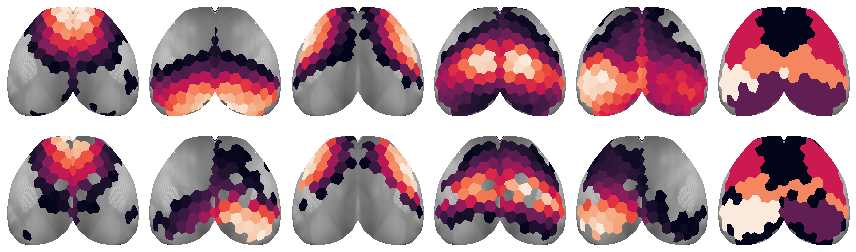

In [43]:
quick_show(tr, tr_meta)

------------------------------    n_top = 000    ------------------------------

BOLD (corr)   : : :   ovp: 0.9718,  disj: 0.9533

Ca2  (corr)   : : :   ovp: 0.9774,  disj: 0.9429

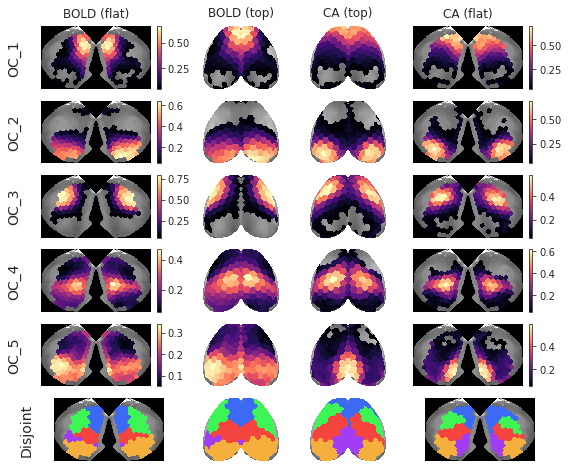

Similarity between OCs (correlation):  Avg = 0.805
OC1: 0.77, OC2: 0.88, OC3: 0.91, OC4: 0.88, OC5: 0.59,

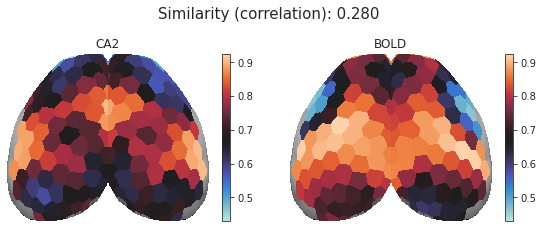

-------------------------------------------------------------------------------

------------------------------    n_top = 001    ------------------------------

BOLD (corr)   : : :   ovp: 0.9142,  disj: 0.8546

Ca2  (corr)   : : :   ovp: 0.9607,  disj: 0.9688

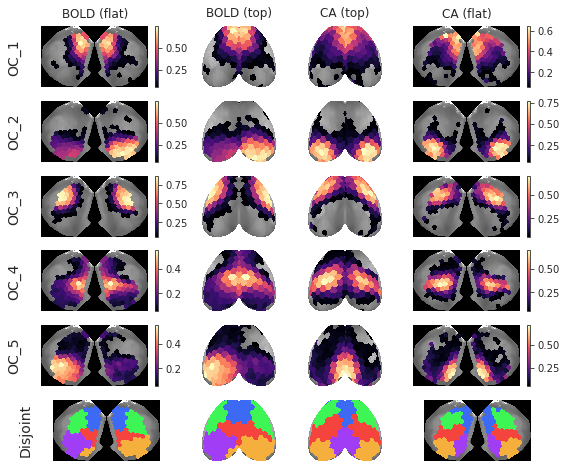

Similarity between OCs (correlation):  Avg = 0.684
OC1: 0.88, OC2: 0.79, OC3: 0.84, OC4: 0.59, OC5: 0.32,

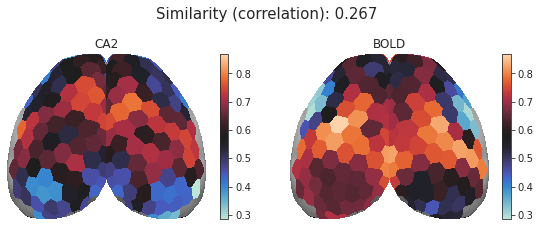

-------------------------------------------------------------------------------

------------------------------    n_top = 100    ------------------------------

BOLD (corr)   : : :   ovp: 0.8769,  disj: 0.8390

Ca2  (corr)   : : :   ovp: 0.9725,  disj: 0.9636

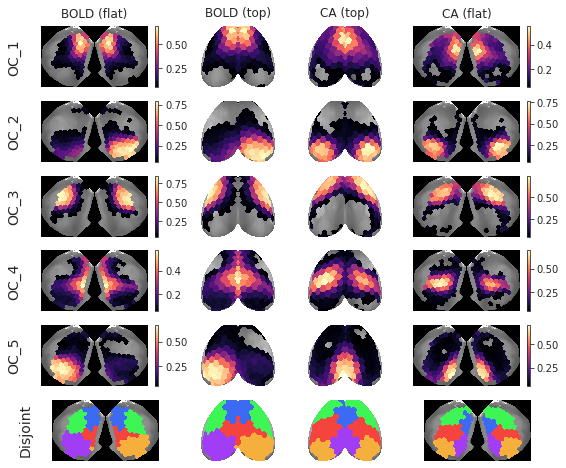

Similarity between OCs (correlation):  Avg = 0.586
OC1: 0.84, OC2: 0.71, OC3: 0.76, OC4: 0.34, OC5: 0.28,

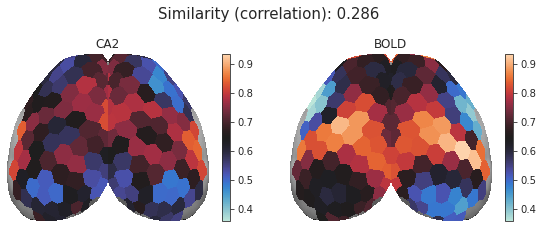

-------------------------------------------------------------------------------

------------------------------    n_top = 200    ------------------------------

BOLD (corr)   : : :   ovp: 0.8704,  disj: 0.8286

Ca2  (corr)   : : :   ovp: 0.9695,  disj: 0.9584

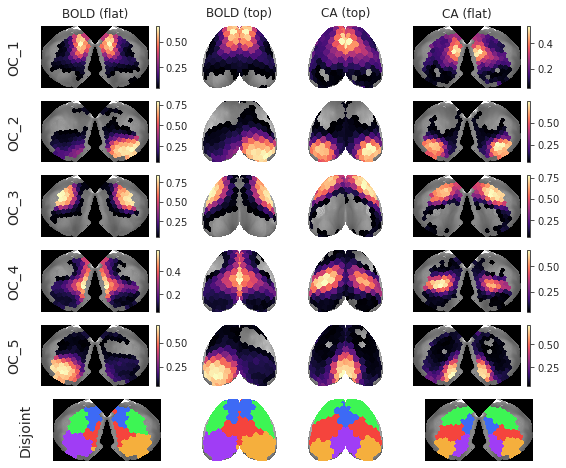

Similarity between OCs (correlation):  Avg = 0.556
OC1: 0.78, OC2: 0.70, OC3: 0.74, OC4: 0.26, OC5: 0.30,

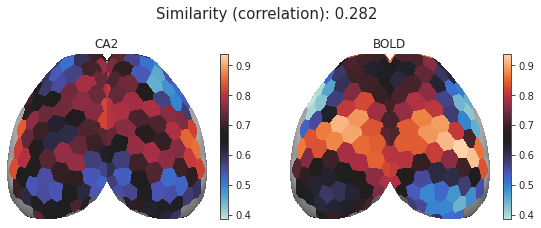

-------------------------------------------------------------------------------

------------------------------    n_top = 300    ------------------------------

BOLD (corr)   : : :   ovp: 0.8696,  disj: 0.8338

Ca2  (corr)   : : :   ovp: 0.9674,  disj: 0.9533

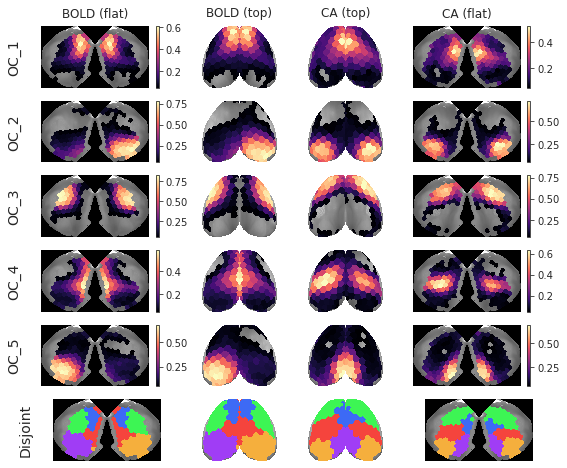

Similarity between OCs (correlation):  Avg = 0.538
OC1: 0.75, OC2: 0.69, OC3: 0.73, OC4: 0.20, OC5: 0.31,

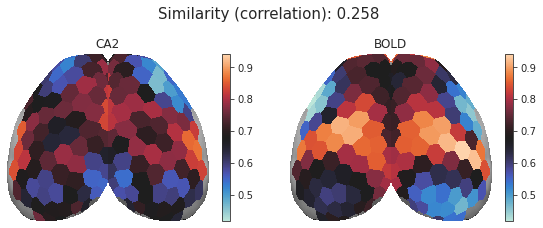

-------------------------------------------------------------------------------

CPU times: user 39min 11s, sys: 4min 17s, total: 43min 29s
Wall time: 30min 9s


In [4]:
%%time

for n_top in [0, 1, 100, 200, 300]:
    print('-' * 30, f'   n_top = {n_top:03d}   ', '-' * 30)
    
    gr_ca = Group(**props_ca).fit_group(force=True, n_top=n_top)
    gr_bo = Group(**props_bo).fit_group(force=True, n_top=n_top)
    gr_ca = Group(**props_ca).fit_group()
    gr_bo = Group(**props_bo).fit_group()

    sim = dist2sim(sp_dist.cdist(
        XA=gr_bo.grp_pi,
        XB=gr_ca.grp_pi,
        metric='correlation',
    ))
    mapping = find_best_match(sim)
    ids = list(mapping.values())

    gr_bo.pi = gr_bo.grp_pi
    gr_ca.pi = gr_ca.grp_pi[ids]
    
    proj_bo = gr_bo.project_vec()
    proj_ca = gr_ca.project_vec()
    
    h = np.concatenate([np.expand_dims(gr_ca.grp_h, 0), np.expand_dims(gr_bo.grp_h, 0)])
    proj = gr_ca.project_vec(h, add_disjoint=False)
    tr = gr_ca.trim2d(proj)

    ovp, disj = gr_bo.pi_symmetry_score(decimals=5, metric='correlation')
    print(f"BOLD (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
    ovp, disj = gr_ca.pi_symmetry_score(decimals=5, metric='correlation')
    print(f"Ca2  (corr)   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

    _ = gr_ca.show(
        proj_1=proj_bo,
        proj_2=proj_ca,
        cmaps=('magma',) * 2,
        labels=('BOLD', 'CA'),
        fix_cmap=False,
        min_thres=0.05,
    )
    score = dist2sim(sp_dist.cdist(gr_bo.pi, gr_ca.pi, metric='correlation')).diagonal()
    msg = f'Similarity between OCs (correlation):  Avg = {score.mean():0.3f}\n'
    for i in range(num_k):
        msg += f'OC{i+1}: {score[i]:0.2f}, '
    msg += '\n'
    print(msg)
    
    vmin = np.nanmin(tr['proj-top'][tr['proj-top'].nonzero()])
    vmax = np.nanmax(tr['proj-top'][tr['proj-top'].nonzero()])
    kwargs = {'cmap': 'icefire', 'vmin': vmin, 'vmax': vmax}

    fig, axes = create_figure(1, 2, (8, 3))
    for ax in axes.flat:
        ax.imshow(mwh(tr['top'] == 0, tr['top']), cmap='Greys_r')
    im = axes[0].imshow(mwh(tr['proj-top'][0] == 0, tr['proj-top'][0]), **kwargs)
    plt.colorbar(im, ax=axes[0])
    axes[0].set_title('CA2')
    im = axes[1].imshow(mwh(tr['proj-top'][1] == 0, tr['proj-top'][1]), **kwargs)
    plt.colorbar(im, ax=axes[1])
    axes[1].set_title('BOLD')
    sim_h = sp_stats.pearsonr(gr_ca.grp_h, gr_bo.grp_h)[0]
    fig.suptitle(f'Similarity (correlation): {sim_h:0.3f}', y=1.04, fontsize=15)
    remove_ticks(axes)
    plt.show()
    
    print('-' * 79)
    print('\n\n')